In [16]:
import numpy as np
from tqdm import tqdm
import torch
from models import HapbertaForMaskedLM
from datasets import load_from_disk
from collators import HaploSimpleDataCollator
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
model = HapbertaForMaskedLM.from_pretrained(
    "./models/hapberta2d/"
)
model.to("cuda")
model.eval()

HapbertaForMaskedLM(
  (roberta): HapbertaAxialModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(6, 768, padding_idx=4)
      (position_embeddings): None
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): HapbertaAxialEncoder(
      (layer): ModuleList(
        (0-11): 12 x HapbertaAxialLayer(
          (row_attn): NormalizedResidualBlock(
            (layer): RowSelfAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (dist_bias): RelativePosAttnBias(
                (relative_attention_bias): Embedding(32, 12)
              )
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
              (d

In [3]:
ds = load_from_disk("dataset/tokenized")
collator = HaploSimpleDataCollator()

ds = ds.shuffle().select(range(1000))

In [14]:
batch_size = 16
embeds = []

with torch.no_grad():
    for i in tqdm(range(0, len(ds), batch_size)):
        batch_samples = [ds[j] for j in range(i, min(i + batch_size, len(ds)))]
        batch = collator(batch_samples)
        # Move tensors to device
        for k in batch:
            if isinstance(batch[k], torch.Tensor):
                batch[k] = batch[k].to("cuda")
        
        output = model(batch["input_ids"], batch["distances"], batch["attention_mask"],
                       return_hidden_states=True)
        
        embeds.append(output["hidden_states"].cpu().numpy())
        

100%|██████████| 63/63 [01:21<00:00,  1.29s/it]


In [15]:
embeds = np.concatenate(embeds, axis=0)

In [18]:
embeds_pooled = np.mean(embeds, axis=(1, 2))

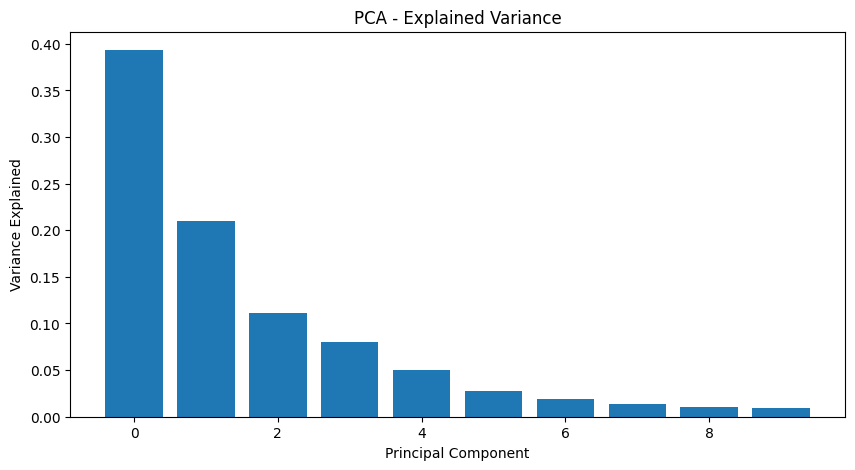

In [32]:
# pca on embeds
embed_pca = PCA(n_components=10)
embed_pca.fit(embeds_pooled)

reduced_embeds = embed_pca.transform(embeds_pooled)

# plot explained variance
var = embed_pca.explained_variance_ratio_
plt.figure(figsize=(10, 5))
plt.bar(range(len(var)), var)
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.title("PCA - Explained Variance")
plt.show()

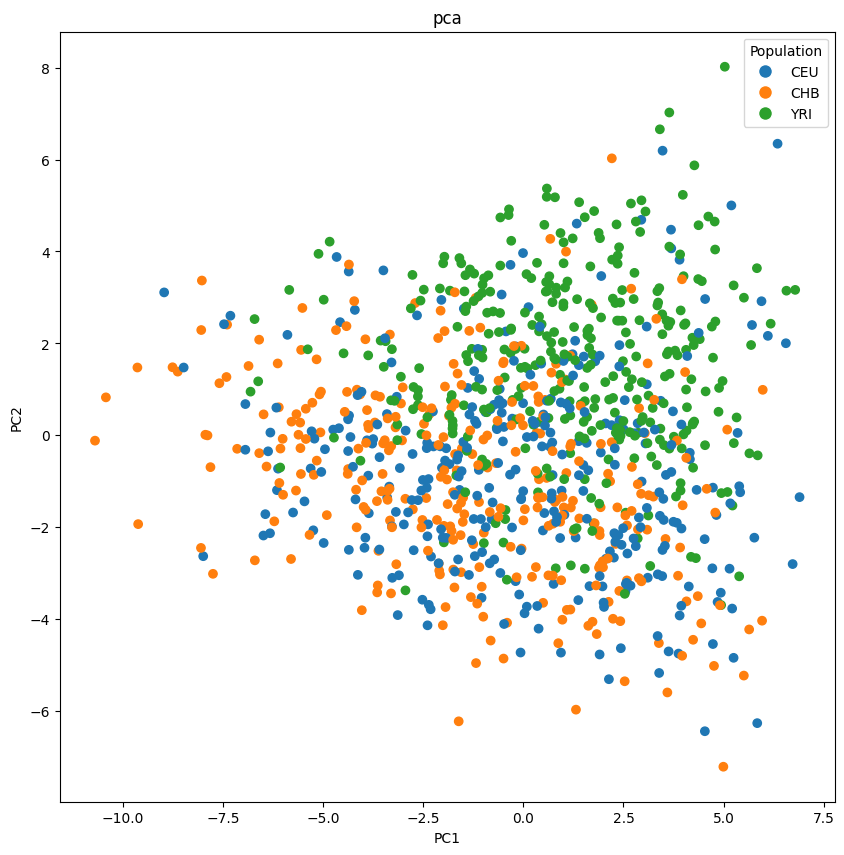

In [38]:
# plot first 2 PCs
colors = {'CEU': 'tab:blue', 'CHB': 'tab:orange', 'YRI': 'tab:green'}
pop_labels = ds["pop"]
pop_colors = [colors[label] for label in pop_labels]

plt.figure(figsize=(10, 10))
scatter = plt.scatter(reduced_embeds[:, 0], reduced_embeds[:, 1], c=pop_colors)
# Add legend
handles = [plt.Line2D([0], [0], marker='o', color='w', label=pop, markerfacecolor=color, markersize=10)
           for pop, color in colors.items()]
plt.legend(handles=handles, title="Population")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("pca")
plt.show()